In [1]:
import time
import os
#os.environ["CUDA_VISIBLE_DEVICES"]="-1"    
import matplotlib.pyplot as plt
import tensorflow as tf
import MetaTrader5 as mt5
import pandas as pd    
import numpy as np
from datetime import datetime, timedelta
from IPython.display import clear_output
from collections import deque
from tqdm import tqdm
import random
import cv2
import pickle
dlen = 120
pos_size = 0.05 * 100000
comm = 15/100000
res_high = 100

In [2]:
def Load(file):
    f = open(file, "rb")
    obj = pickle.load(f)
    f.close()
    return obj

In [3]:
class candle_class:
    def __init__(self, o,h,l,c,t):
        self.o=o
        self.h=h
        self.l=l
        self.c=c
        self.t=t

class environment:
    def __init__(self):
        self.data_dir = "./archive"
        #print(self.files)
        #self.reset()

    def reset(self, first = False):
        self.files = [self.data_dir+"/"+x for x in os.listdir(self.data_dir) if "candle_classes" in x]
        p = random.choice(self.files)
        print("using",p)
        self.candles = Load(p)
        #print(self.candles)
        
        
        self.current_index = 0
        if first:
            self.current_index = random.randint(0,len(self.candles)-50000)
            
        self.d1_candles = deque(maxlen = dlen)
        self.h4_candles = deque(maxlen = dlen)
        self.h1_candles = deque(maxlen = dlen)
        self.m15_candles = deque(maxlen = dlen)
        
        self.position = 0
        self.entry_price = 0
        self.equity = 0
        self.current_equity = 0
        self.balance = 0
        
            
        self.get_sample_candles()
        return [self.scale_candles(self.m15_candles), self.scale_candles(self.h1_candles), self.scale_candles(self.h4_candles), self.scale_candles(self.d1_candles), self.position]
            
    def close(self):
        if self.position !=0:
            self.balance = self.equity
            self.position = 0
        
    def step(self, action) :
        last_equity = self.equity
        reset_entry_price = False
        if action == 1: # long
            if self.position != 1:
                self.close()
                self.position = 1
                self.balance -= pos_size * comm
                reset_entry_price = True
                
        if action == 0: # short
            if self.position != -1:
                self.close()
                self.position = -1
                self.balance -= pos_size * comm
                reset_entry_price = True
        
        
        if self.get_sample_candles() == -1:
            print("error")
            return -1
            
        current_close = self.m15_candles[-1].c
        if reset_entry_price: self.entry_price = self.m15_candles[-1].o
        
        percent_change = (current_close - self.entry_price) / self.entry_price

        self.equity = self.balance + percent_change * pos_size * self.position
        
        reward = self.equity - last_equity
        next_observation = [self.scale_candles(self.m15_candles), self.scale_candles(self.h1_candles), self.scale_candles(self.h4_candles), self.scale_candles(self.d1_candles), self.position]
            
        return next_observation, reward, len(self.candles) == self.current_index
        
        
    def get_sample_candles(self):
        if len(self.candles) == self.current_index:
            return -1
        while True:
            # return dlen candles of d1, h4, h1 and m15
            current_candle = self.candles[self.current_index]
            current_hour = int(current_candle.t.split(":")[0])
            current_closing_minute = int(current_candle.t.split(":")[1])

            # m15 candles:
            open_minute = int(current_closing_minute / 15) * 15 # candle saved the last minute but opening minute is better to use
            self.m15_candles.append(candle_class(current_candle.o, current_candle.h, current_candle.l, current_candle.c, str(current_hour) +":"+str(open_minute)))

            # h1 candles:
            if  open_minute == 0: # a new hour candle started
                new_candle = candle_class(current_candle.o, current_candle.h, current_candle.l, current_candle.c, str(current_hour)+":00")
                self.h1_candles.append(new_candle)
            else:
                if len(self.h1_candles) > 0:
                    self.h1_candles[-1].c = current_candle.c
                    self.h1_candles[-1].h = max(current_candle.h, self.h1_candles[-1].h)
                    self.h1_candles[-1].l = min(current_candle.l, self.h1_candles[-1].l)

            # h4 candles:
            # create a new h4 candle when hour is 17, 21, 1, 5, 9, 13
            if  current_hour == 17 or current_hour == 21 or current_hour == 1 or current_hour == 5 or current_hour == 9 or current_hour == 13:
                new_candle = candle_class(current_candle.o, current_candle.h, current_candle.l, current_candle.c, str(current_hour)+":00")
                self.h4_candles.append(new_candle)
            else:
                if len(self.h4_candles) > 0:
                    self.h4_candles[-1].c = current_candle.c
                    self.h4_candles[-1].h = max(current_candle.h, self.h4_candles[-1].h)
                    self.h4_candles[-1].l = min(current_candle.l, self.h4_candles[-1].l)

            # d1 candles:
            # create a new d1 candle when hour is 17
            if  current_hour == 17:
                new_candle = candle_class(current_candle.o, current_candle.h, current_candle.l, current_candle.c, str(current_hour)+":00")
                self.d1_candles.append(new_candle)
            else:
                if len(self.d1_candles) > 0:
                    self.d1_candles[-1].c = current_candle.c
                    self.d1_candles[-1].h = max(current_candle.h, self.d1_candles[-1].h)
                    self.d1_candles[-1].l = min(current_candle.l, self.d1_candles[-1].l)

            self.current_index+=1    
            if len(self.d1_candles) == dlen:
                break

        return self.m15_candles,  self.h1_candles, self.h4_candles, self.d1_candles
    
    
    def scale_candles(self, candles):
        def scale_p(p):
            return int((p - max_l) / hlrange * (res_high))
        max_h = 0
        max_l = 1000000
        for i in candles:
            if i.h > max_h:
                max_h = i.h
            if i.l < max_l:
                max_l = i.l
        hlrange = max_h - max_l
        
        
        def scale_time(t):
            hour = int(t.split(":")[0])
            minute = int(t.split(":")[1])
            total = hour * 60 + minute
            max_t = 24*60
            scaled = total / max_t
            return scaled
            
        
        
        image = []
        for i in candles:
            clm = np.zeros(shape = (res_high+1))
            color = 1 if i.o<i.c else -1
            high_scaled = scale_p(i.h)
            low_scaled = scale_p(i.l)
            clm[low_scaled:high_scaled] = 0.5 * color
            open_scaled = scale_p(i.o)
            close_scaled = scale_p(i.c)
            if color == 1:
                clm[open_scaled:close_scaled+1] = color
            if color == -1:
                clm[close_scaled:open_scaled+1] = color
                
            c_time = scale_time(i.t)
            clm[-1] = c_time
            image.append(clm)
        
        current_close = candles[-1].c
        scaled_close = scale_p(current_close)
        clm = np.zeros(shape = (res_high+1))
        clm[scaled_close] = 1
        image.append(clm)
        
        return np.array(image).T
        
        

using ./archive/15_USDCHF.csv_candle_classes


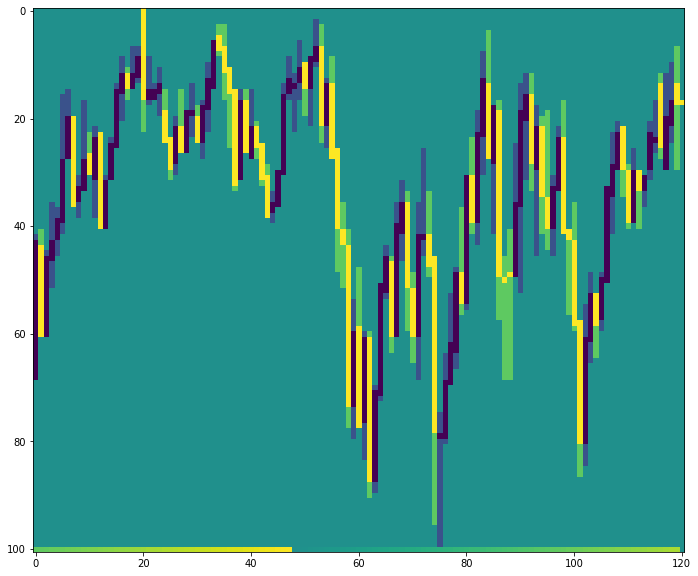

In [4]:
x = environment()
m15,h1,h4,d1,pos = x.reset(True)
plt.figure(figsize =(15,10))
plt.imshow(m15)

(1, 101, 121)
(1, 100, 120)
(1, 120)
(1, 101)


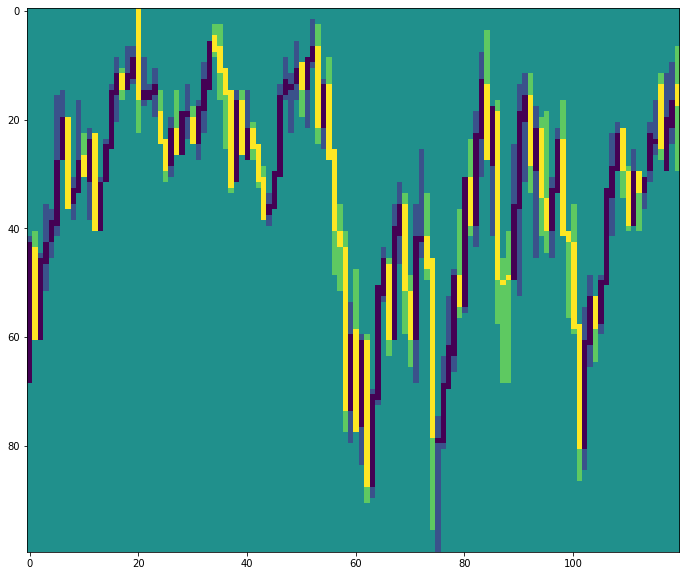

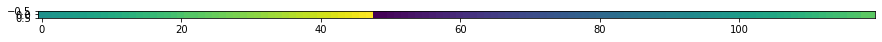

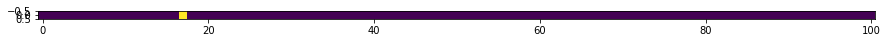

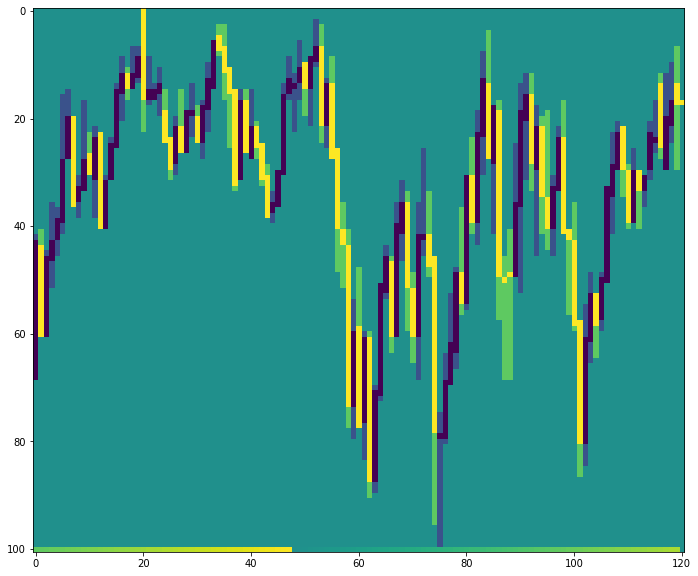

In [5]:
#x = tf.keras.layers.Input(shape = (res_high+1, dlen+1))
x = tf.convert_to_tensor(np.array(m15).reshape(1,res_high+1, dlen+1))
#x1 = image
#x2 = time
x1 = x[::, :-1, :-1]
x2 = x[::,-1,:-1]
current_pos = x[::,::, -1]
print(x.shape)
print(x1.shape)
print(x2.shape)
print(current_pos.shape)

plt.figure(figsize =(15,10))
plt.imshow(x1.numpy()[0])
plt.show()
plt.figure(figsize =(15,10))
plt.imshow(x2.numpy())
plt.show()
plt.figure(figsize =(15,10))
plt.imshow(current_pos.numpy())
plt.show()
plt.figure(figsize =(15,10))
plt.imshow(x.numpy()[0])
plt.show()

In [ ]:


tf.keras.backend.clear_session()

def proc_chart(x):
    #x1 = image
    #x2 = time
    x1 = x[::, :-1, :-1]
    x2 = x[::,-1,:-1]
    current_pos = x[::,::, -1]

    x1 = tf.keras.layers.Reshape((res_high, dlen, 1))(x1)
    
    x5 = tf.keras.layers.Conv2D(16, 3,activation="relu", padding="same")(x1)
    x1 = tf.keras.layers.Concatenate()([x1,x5])
    x5 = tf.keras.layers.Conv2D(16, 3,activation="relu", padding="same")(x1)
    x1 = tf.keras.layers.Concatenate()([x1,x5])


    x1 = tf.keras.layers.Dense(16)(x1)
    x1 = tf.keras.layers.LeakyReLU()(x1)
    
    x1 = tf.transpose(x1,perm=[0, 2, 1, 3])
    x1 = tf.keras.layers.Reshape((dlen, res_high*x1.shape[-1]))(x1)
    x2 = tf.keras.layers.Reshape((dlen, 1))(x2)
    x1 = tf.keras.layers.Concatenate()([x1,x2])
    
    x1 = tf.keras.layers.Dense(128)(x1)
    x1 = tf.keras.layers.LeakyReLU()(x1)
    x1 = tf.keras.layers.Dense(64)(x1)
    x1 = tf.keras.layers.LeakyReLU()(x1)
    x1 = tf.keras.layers.GRU(64, return_sequences = True)(x1)

    x1 = tf.keras.layers.Dense(256)(x1)
    x1 = tf.keras.layers.LeakyReLU()(x1)
    x1 = tf.keras.layers.Dense(256)(x1)
    x1 = tf.keras.layers.LeakyReLU()(x1)
    x1 = tf.keras.layers.Dense(32)(x1)
    x1 = tf.keras.layers.LeakyReLU()(x1)
    x1 = tf.keras.layers.Dense(16)(x1)
    x1 = tf.keras.layers.LeakyReLU()(x1)
    x1 = tf.keras.layers.LayerNormalization()(x1)
    x1 = tf.keras.layers.Flatten()(x1)
    x1 = tf.keras.layers.Concatenate()([x1,current_pos])
    return x1
    
if True:
    input_m15 = tf.keras.layers.Input(shape = (res_high+1, dlen+1))
    input_h1 = tf.keras.layers.Input(shape = (res_high+1, dlen+1))
    input_h4 = tf.keras.layers.Input(shape = (res_high+1, dlen+1))
    input_d1 = tf.keras.layers.Input(shape = (res_high+1, dlen+1))
    
    x1 = proc_chart(input_m15)
    x2 = proc_chart(input_h1)
    x3 = proc_chart(input_h4)
    x4 = proc_chart(input_d1)
    
    input_net_position = tf.keras.layers.Input(shape = (1))


    x = tf.keras.layers.Concatenate()([x1,x2,x3,x4,input_net_position])
    
    x = tf.keras.layers.Dense(2048)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dense(2048)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dense(1024)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dense(1024)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    
    outputs = tf.keras.layers.Dense(2, activation = "linear", use_bias=False, dtype="float32")(x)
    model = tf.keras.Model([input_m15,input_h1,input_h4, input_d1, input_net_position], outputs)
    
model.summary()



In [7]:
#states = m15candles, h1candles, h4candles, d1candles, position
#states =(5,dlen), (5,dlen), (5,dlen), (5,dlen), (1)


class DQNAgent:
    def __init__(self, model,
                 n_actions,
                 memory_size = 100000, 
                 optimizer = tf.keras.optimizers.Adam(0.0005), 
                 gamma = 0.99,
                 batch_size =32,
                 name = "dqn1",
                 target_model_sync = 1000,
                 exploration = 0.01
                ):
        self.exploration = exploration
        self.gamma = gamma
        self.n_actions = n_actions
        self.batch_size = batch_size
        self.model = model
        self.name = name
        self.memory_size = memory_size
        self.optimizer = optimizer
        self.m1 = np.eye(self.n_actions, dtype="float32")
        self.target_model = tf.keras.models.clone_model(self.model)
        self.target_model_sync = target_model_sync
   
        self.memory = deque(maxlen = self.memory_size)
      
    
    def copy_weights(self):
        self.target_model.set_weights(self.model.get_weights())
      
    def load_weights(self):
        self.model.load_weights(self.name)
    def save_weights(self):
        self.model.save_weights(self.name, overwrite = True)
        
    @tf.function(jit_compile = False)
    def model_call(self, x):
        x1, x2, x3, x4, x5 = x
        return tf.math.argmax(self.model([x1,x2,x3,x4,x5]), axis = 1)
    
    def select_actions(self, state1, state2, state3, state4, state5):
        if np.random.random() < self.exploration: # random action
            return [np.random.randint(0,self.n_actions) for _ in range(len(state5))]
        
        ret = self.model_call([state1, state2, state3, state4, state5])
        return ret


        
    def observe_sasrt(self, state, action, next_state, reward, terminal):
        self.memory.append([state, action, reward, 1-int(terminal), next_state])
        
    @tf.function(jit_compile = False)
    def get_target_q(self, next_states, rewards, terminals):
        estimated_q_values_next = self.target_model(next_states)
        q_batch = tf.math.reduce_max(estimated_q_values_next, axis=1)
        target_q_values = q_batch * self.gamma * terminals + rewards
        return target_q_values

        
    #@tf.function(jit_compile = False)
    def tstep(self, data):
        states, next_states, rewards, terminals, masks = data
        target_q_values = self.get_target_q(next_states, rewards, terminals)
        
        with tf.GradientTape() as t:
            model_return = self.model(states, training=True) 
            mask_return = model_return * masks
            estimated_q_values = tf.math.reduce_sum(mask_return, axis=1)
            #print(estimated_q_values, mask_return, model_return, masks)
            loss_e = tf.math.square(target_q_values - estimated_q_values)
            loss = tf.reduce_mean(loss_e)
        
        
        gradient = t.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradient, self.model.trainable_variables))
        
        return loss, tf.reduce_mean(estimated_q_values)
    
    
    def data_get_func(self):
        idx = np.random.randint(0, len(self.memory), self.batch_size)
        sarts_batch = [self.memory[i] for i in idx]
        
        states = [x[0] for x in sarts_batch]
        states_1 = np.array([x[0] for x in states], dtype="float32")
        states_2 = np.array([x[1] for x in states], dtype="float32")
        states_3 = np.array([x[2] for x in states], dtype="float32")
        states_4 = np.array([x[3] for x in states], dtype="float32")
        states_5 = np.array([x[4] for x in states], dtype="float32")
        
        actions = [x[1] for x in sarts_batch]
        rewards = np.array([x[2] for x in sarts_batch], dtype="float32")
        terminals = np.array([x[3] for x in sarts_batch], dtype="float32")
        
        next_states = [x[4] for x in sarts_batch]
        next_states_1 = np.array([x[0] for x in next_states], dtype="float32")
        next_states_2 = np.array([x[1] for x in next_states], dtype="float32")
        next_states_3 = np.array([x[2] for x in next_states], dtype="float32")
        next_states_4 = np.array([x[3] for x in next_states], dtype="float32")
        next_states_5 = np.array([x[4] for x in next_states], dtype="float32")
        
        masks = np.array(self.m1[actions])
        return [states_1, states_2, states_3, states_4, states_5], [next_states_1, next_states_2, next_states_3, next_states_4, next_states_5], rewards, terminals, masks

    def update_parameters(self):
        self.total_steps_trained+=1
        if self.total_steps_trained % self.target_model_sync == 0:
            self.copy_weights()

           
        data = self.data_get_func()
        result= self.tstep(data)
   
        return  result
    
    def train(self, num_steps, envs, log_interval = 1000, warmup = 0, train_steps_per_step = 1):
        self.total_steps_trained = -1

        num_envs = len(envs)
        states = [x.reset(True) for x in envs]
        
        current_episode_reward_sum = 0
        times= deque(maxlen=10)
        start_time = time.time()
        
        self.longs = 0
        self.shorts = 0

        self.total_rewards = []
        self.losses = [0]
        self.q_v = [0]
        
        def save_current_run():
            self.save_weights()
            file = open(log_folder+"logs/loss_log.txt", "a")  
            #for loss in self.losses:
                        #file.write(str(loss))
                        #file.write("\n")
            file.write(str(np.mean(self.losses)))
            file.write("\n")
            file.close()

            file = open(log_folder+"logs/qv_log.txt", "a")  
            #for qv in self.q_v:
                        #file.write(str(qv))
                        #file.write("\n")
            file.write(str(np.mean(self.q_v)))
            file.write("\n")
            file.close()

            file = open(log_folder+"logs/rewards_log.txt", "a")  
            #for total_reward in self.total_rewards:
                        #file.write(str(total_reward))
                        #file.write("\n")
                    
            file.write(str(np.mean(self.total_rewards)))
            file.write("\n")
            file.close()
            
    

            self.total_rewards = []
            self.losses = [0]
            self.q_v = [0]
        
        try:
            for i in range(num_steps):
                if i % log_interval == 0:
                    progbar = tf.keras.utils.Progbar(log_interval, interval=0.1, stateful_metrics = ["reward sum", "t", "l/s"])
                    self.longs = 0
                    self.shorts = 0


                states_1 = np.array([x[0] for x in states])
                states_2 = np.array([x[1] for x in states])
                states_3 = np.array([x[2] for x in states])
                states_4 = np.array([x[3] for x in states])
                states_5 = np.array([x[4] for x in states])
                
                actions = self.select_actions(states_1, states_2, states_3, states_4, states_5)
                for action in actions:
                    if action == 0:
                        self.shorts+=1
                    elif action == 1:
                        self.longs+=1

                sasrt_pairs = []
                for index in range(num_envs):
                    sasrt_pairs.append([states[index], actions[index]]+[x for x in envs[index].step(actions[index])])

                next_states = [x[2] for x in sasrt_pairs]

                reward = [x[3] for x in sasrt_pairs]
                current_episode_reward_sum += np.sum(reward)

                self.total_rewards.extend(reward)

                for index, o in enumerate(sasrt_pairs):
                    #print(o)
                    if o[4] == True:
                        next_states[index] = envs[index].reset()
                    self.observe_sasrt(o[0], o[1], o[2], o[3], o[4])

                states = next_states
                if i > warmup:
                    for _ in range(train_steps_per_step):
                        loss, q = self.update_parameters()
                        self.losses.append(loss.numpy())
                        self.q_v.append(q.numpy())
                else:
                    loss, q = 0, 0

                end_time = time.time()
                elapsed = (end_time - start_time) * 1000
                times.append(elapsed)
                start_time = end_time


                if (i+1) % log_interval == 0:
                    #print("-----------")
                    #print("l:", np.mean(self.losses))
                    #print("q:", np.mean(self.q_v))
                    #print("reward sum", current_episode_reward_sum)
                    #print("l/s", (self.longs - self.shorts) / (1+self.longs+self.shorts))
                    #print("t", np.mean(times))
                    #print("-----------")
                    save_current_run()

                progbar.update(i%log_interval+1, values = 
                               [("loss", np.mean(self.losses[-train_steps_per_step:])),
                                ("mean q", np.mean(self.q_v[-train_steps_per_step:])),
                                ("rewards", np.mean(reward)),
                                ("reward sum", current_episode_reward_sum),
                                ("l/s", (self.longs - self.shorts) / (1+self.longs+self.shorts)),
                                ("t", np.mean(times))])
        
        except KeyboardInterrupt:
            print("\n\nbreak!")
        
        save_current_run()
   

In [8]:
resume = False
opt = tf.keras.optimizers.Adam(0.00002)

name = "dqn_trading_1"
log_folder = "./"

agent = DQNAgent(
    model = model, 
    n_actions = 2, 
    memory_size = 100000, 
    gamma=0.95,
    optimizer = opt,
    batch_size = 64, 
    target_model_sync = 500,
    exploration = 0.02,
    name=log_folder+name+".h5")

if resume:
	print("loading weights...")
	agent.load_weights()

In [9]:
x = [environment() for _ in range(4)]
print("warmup...")
n = 1000
agent.train(num_steps = n, envs = x, warmup = n, log_interval = n, train_steps_per_step=1)

warmup...
using ./archive/15_EURUSD.csv_candle_classes
using ./archive/15_EURGBP.csv_candle_classes
using ./archive/15_AUDJPY.csv_candle_classes
using ./archive/15_USDCAD.csv_candle_classes
100/100 [==============================] - 11s 63ms/step - loss: 0.0000e+00 - mean q: 0.0000e+00 - rewards: -0.2269 - reward sum: -90.7611 - l/s: 0.0898 - t: 42.3071


c:\users\root\appdata\local\programs\python\python36\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\root\appdata\local\programs\python\python36\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [10]:
len(agent.memory)

400

In [ ]:
x = [environment() for _ in range(4)]
print("training...")
n = 100000000
agent.train(num_steps = n, envs = x, warmup = 0, log_interval = 1000, train_steps_per_step=1)
print("done")

training...
using ./archive/15_GBPUSD.csv_candle_classes
using ./archive/15_EURGBP.csv_candle_classes
using ./archive/15_EURGBP.csv_candle_classes
using ./archive/15_EURCHF.csv_candle_classes
 703/1000 [====================>.........] - ETA: 2:07 - loss: 1.4984 - mean q: 0.3666 - rewards: -0.1303 - reward sum: -926.3776 - l/s: -0.0192 - t: 469.0679

In [ ]:
#def plot_candles(candles, name):
#    def scale_p(p):
#        return (p - max_l) / hlrange * h
#    
#    w = 300
#    h = 200
#    canvas = np.zeros((h,w,3), np.uint8) 
#    l = dlen
#    single_candle_w = w / l * 0.95
#    max_h = 0
#    max_l = 1000000
#    for i in candles:
#        if i.h > max_h:
#            max_h = i.h
#        if i.l < max_l:
#            max_l = i.l
#    hlrange = max_h - max_l
#    
#    for i in range(len(candles)):  
#        color = (0,200,0) if candles[i].c > candles[i].o else (0,0,200)
#        cv2.rectangle(canvas, (int(i*single_candle_w),int(scale_p(candles[i].o))), (int((i+1)*single_candle_w),int(scale_p(candles[i].c))), color, -1)
#        cv2.line(canvas, (int((i+0.5)*single_candle_w),int(scale_p(candles[i].h))), (int((i+0.5)*single_candle_w),int(scale_p(candles[i].l))), color)
#
#    canvas = canvas[::-1]
#    
#    cv2.imshow(name, canvas)
#    cv2.waitKey(1)

In [ ]:
#while True:
#    m15,h1,h4,d1 = x.get_sample_candles()
#    
#    plot_candles(m15,"m15")
#    plot_candles(h1, "h1")
#    plot_candles(h4, "h4")
#    plot_candles(d1, "d1")
#    
#    time.sleep(0.5)
#    break

In [ ]:
#m15,h1,h4,d1 = x.get_sample_candles()
#o,h,l,c,t = x.scale_candles(m15)
#plt.plot(o)
#plt.plot(h)
#plt.plot(l)
#plt.plot(c)
#plt.plot(t)

In [ ]:
#hour_offset = 8 # time - hour_offset = ny local time
#lookback = 2000
#mt5.initialize()
#authorized=mt5.login(25031341, password = "!geH2e4Pi!Ka", server = "TickmillUK-Demo")
#mt5.account_info()
#authorized

#def get_prices(symbol, tf):
#    t = int(time.time()) + 60*60*24
#
#    prices = mt5.copy_rates_from(symbol, tf, t, lookback)
#    
#    candles = []
#    for t,o,h,l,c,_,_,_ in prices:
#        t = datetime.fromtimestamp(int(t)) - timedelta (hours=hour_offset)
#        x = candle_class()
#        x.h=h
#        x.l=l
#        x.o=o
#        x.c=c
#        x.t=t
#        candles.append(x)
#    
#    
#    return candles